In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

kepler


Get tram single label data:

In [ ]:
%%bash

mkdir -p ../data/input
wget -O ../data/input/single_label.json https://raw.githubusercontent.com/center-for-threat-informed-defense/tram/main/data/tram2-data/single_label.json

In this version, we will consider the text, tactic and document title, all 3 of them as nodes.
The ontology then will be:

Nodes: 
    text, technique, doc_title
    
Relationships: 
    uses, found-in

Graph triple types will be:
    text uses technique
    text found-in doc_title
    technique found-in doc_title

In [4]:
data = pd.read_json('../data/input/single_label.json')

In [5]:
data

,text,label,doc_title
0,This file extracts credentials from LSASS simi...,T1003.001,NotPetya Technical Analysis A Triple Threat F...
1,It calls OpenProcess on lsass.exe with access ...,T1003.001,NotPetya Technical Analysis A Triple Threat F...
2,It spreads to Microsoft Windows machines using...,T1210,NotPetya Technical Analysis A Triple Threat F...
3,SMB exploitation via EternalBlue,T1210,NotPetya Technical Analysis A Triple Threat F...
4,SMBv1 Exploitation via EternalBlue,T1210,NotPetya Technical Analysis A Triple Threat F...
...,...,...,...
5084,collects local files and information from the ...,T1005,AA21076A TrickBot Malware
5085,uses HTTPS to communicate with its C2 servers,T1071.001,AA21076A TrickBot Malware
5086,samples have used HTTP over ports 447 and 8082...,T1071.001,AA21076A TrickBot Malware
5087,downloads several additional files and saves t...,T1105,AA21076A TrickBot Malware


Getting all unique labels, doc_titles and text:

In [6]:
all_techniques = data['label'].explode().dropna().unique()
all_techniques

array(['T1003.001', 'T1210', 'T1570', 'T1140', 'T1218.011', 'T1059.003',
       'T1057', 'T1518.001', 'T1106', 'T1082', 'T1016', 'T1078', 'T1047',
       'T1027', 'T1056.001', 'T1083', 'T1053.005', 'T1070.004', 'T1105',
       'T1090', 'T1005', 'T1574.002', 'T1071.001', 'T1484.001',
       'T1204.002', 'T1055', 'T1562.001', 'T1033', 'T1566.001', 'T1219',
       'T1547.001', 'T1021.001', 'T1543.003', 'T1569.002', 'T1036.005',
       'T1112', 'T1041', 'T1110', 'T1190', 'T1564.001', 'T1113',
       'T1573.001', 'T1095', 'T1552.001', 'T1012', 'T1074.001',
       'T1548.002', 'T1068', 'T1072', 'T1557.001'], dtype=object)

In [7]:
vc = data['label'].fillna('** Unlabelled').value_counts()
vc

label
T1027        685
T1140        455
T1059.003    345
T1055        283
T1105        262
T1106        202
T1078        170
T1071.001    146
T1090        139
T1082        137
T1003.001    108
T1053.005    106
T1112        104
T1083         98
T1562.001     95
T1021.001     94
T1204.002     87
T1566.001     86
T1070.004     86
T1057         82
T1041         82
T1574.002     81
T1047         75
T1036.005     68
T1056.001     65
T1005         64
T1110         64
T1547.001     63
T1570         58
T1016         55
T1573.001     53
T1218.011     53
T1219         52
T1190         51
T1543.003     50
T1095         50
T1033         49
T1113         49
T1518.001     36
T1548.002     27
T1012         26
T1074.001     25
T1484.001     23
T1569.002     23
T1552.001     20
T1564.001     17
T1210         16
T1068         10
T1072         10
T1557.001      4
Name: count, dtype: int64

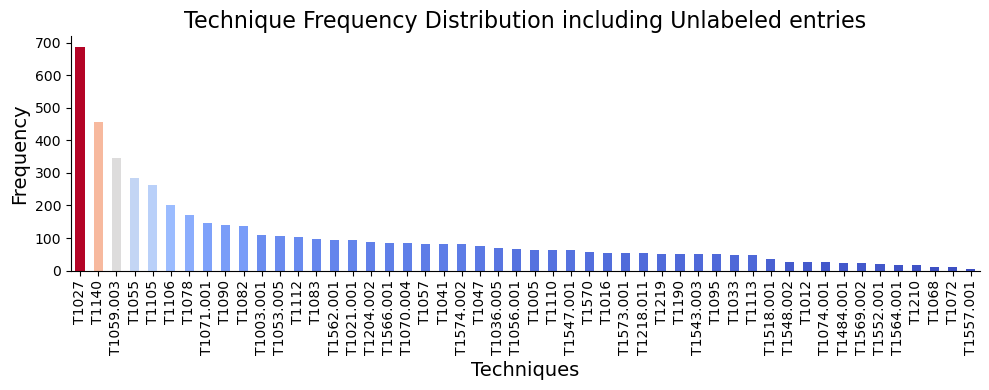

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

plt.figure(figsize=(10, 4))
vc.plot(kind='bar')

# Create a color map
cmap = plt.get_cmap('coolwarm')

# Normalize the counts to range between 0 and 1 to fit into the color map
norm = mcolors.Normalize(vmin=vc.min(), vmax=vc.max())

# Plot the data with color gradient
vc.plot(kind='bar', color=cmap(norm(vc.values)))

plt.title('Technique Frequency Distribution including Unlabeled entries', fontsize=16)
plt.xlabel('Techniques', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()

ax = plt.gca()  # Get the current axes

# Hide the top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
# ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_facecolor('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.draw()
plt.savefig('single_technique_na.pdf', format='pdf')
plt.show()


In [8]:
freq = data.groupby("label").size()
freq

label
T1003.001    108
T1005         64
T1012         26
T1016         55
T1021.001     94
T1027        685
T1033         49
T1036.005     68
T1041         82
T1047         75
T1053.005    106
T1055        283
T1056.001     65
T1057         82
T1059.003    345
T1068         10
T1070.004     86
T1071.001    146
T1072         10
T1074.001     25
T1078        170
T1082        137
T1083         98
T1090        139
T1095         50
T1105        262
T1106        202
T1110         64
T1112        104
T1113         49
T1140        455
T1190         51
T1204.002     87
T1210         16
T1218.011     53
T1219         52
T1484.001     23
T1518.001     36
T1543.003     50
T1547.001     63
T1548.002     27
T1552.001     20
T1557.001      4
T1562.001     95
T1564.001     17
T1566.001     86
T1569.002     23
T1570         58
T1573.001     53
T1574.002     81
dtype: int64

In [9]:
doc_titles = data['doc_title'].explode().dropna().unique()
doc_titles

array(['NotPetya Technical Analysis  A Triple Threat File Encryption MFT Encryption Credential Theft',
       'Earth Zhulong Familiar Patterns Target Southeast Asian Firms',
       'Malware Spotlight Camaro Dragons TinyNote Backdoor',
       'Rorschach  A New Sophisticated and Fast Ransomware  Check Point Research',
       'Bypassing Intel CET with Counterfeit Objects  OffSec',
       'Emotet Strikes Again  LNK File Leads to Domain Wide Ransomware  The DFIR Report',
       'Malware Analysis LummaC2 Stealer',
       'FedEx Phishing Campaign Abusing TrustedForm and PAAY',
       'Take a NetWalk on the Wild Side',
       'Malicious OAuth applications used to compromise email servers and spread spam  Microsoft Security Blog',
       'Nefilim Ransomware',
       'Deja Vu All Over Again Tax Scammers at Large',
       'Threat Assessment Black Basta Ransomware',
       'Hafniuminspired cyberattacks neutralized by AI',
       'eSentire Threat Intelligence Malware Analysis BatLoader',
       'Ea

/var/folders/c4/syfmh0gs1jbb5q_69pf2hs4c0000gn/T/ipykernel_26640/69199621.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize = 12, rotation=45)


<Figure size 640x480 with 0 Axes>

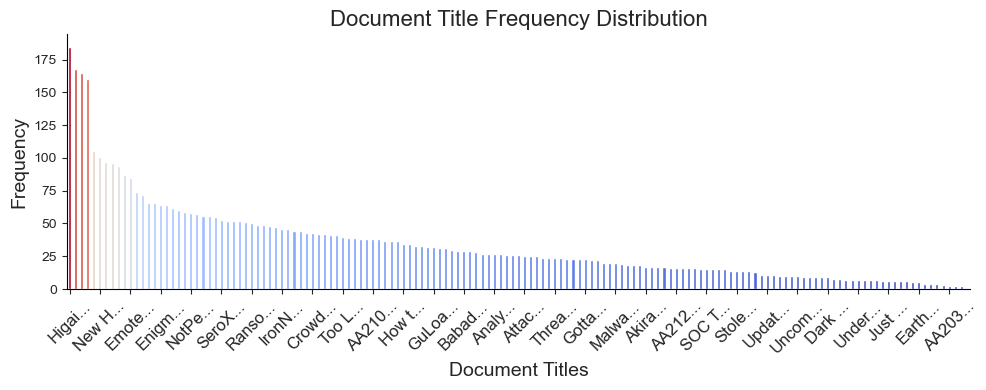

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

dc = data['doc_title'].value_counts()
new_labels = [label[:5] for label in dc.index]

plt.clf()
plt.figure(figsize=(10, 4))

# Create a color map
cmap = plt.get_cmap('coolwarm')

# Normalize the counts to range between 0 and 1 to fit into the color map
norm = mcolors.Normalize(vmin=dc.min(), vmax=dc.max())

# Plot the data with color gradient
dc.plot(kind='bar', color=cmap(norm(dc.values)))

plt.title('Document Title Frequency Distribution', fontsize=16)
plt.xlabel('Document Titles', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Set xticks to display every 10th label
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

# New code
labels = ax.get_xticklabels()
new_labels = [f'{label.get_text()[:5]}...' for label in labels]  # Change 10 to any number you want
ax.set_xticklabels(new_labels, fontsize = 12, rotation=45)
plt.tight_layout()

# Hide the top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_facecolor('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.draw()
plt.savefig('single_title.pdf', format='pdf')
plt.show()


In [ ]:
text = data['text'].to_numpy()
text

Adding them all in one place labels, text, doc_titles:
there are 50 labels, 149 doc_titles and 5089 text

In [ ]:
nodes = np.concatenate((all_techniques, doc_titles, text))
nodes

The node list will then have 
    0-49 techniques
    50-198 doc_titles 
    199-5287 text
    
Now to make the numeric triples, we will use the indexes of the nodes from the nodes list.


Let us say that of the two relationships, uses = 0 and found-in = 1

1. we make the triples for text uses technique
2. we make the triples for text found-in doc_title
3. we make the triples for technique found-in doc_title

In [ ]:
triples = []
tech2doc = []

np_data = data.to_numpy()

for row in np_data:
    text_index = np.where(nodes == row[0])[0][0]
    technique_index = np.where(nodes == row[1])[0][0]
    doc_title_index = np.where(nodes == row[2])[0][0]

    triples.extend(
        ((text_index, 0, technique_index),
         (text_index, 1, doc_title_index))
    )
    tech2doc.append((technique_index, 1, doc_title_index))
    
print(f'Number of text2tech, text2doc: {len(triples)/2}')
tech2doc = np.unique(tech2doc, axis=0)
print(f'Number of tech2doc: {len(tech2doc)}')
triples = np.array(triples)
triples = np.append(triples, tech2doc, axis=0)

In [ ]:
triples

In [ ]:
len(triples)

In [ ]:
print(f'Number of Techniques: {len(all_techniques)}')
print(f'Number of Doc Titles: {len(doc_titles)}')
print(f'Number of Texts: {len(text)}')
print(f'Number of Nodes: {len(nodes)}')
print(f'Number of Triples: {len(triples)}')


In [ ]:
assert len(triples) == 2 * len(np_data) + len(tech2doc)

split the triples into train, validation, test and save them to a file

In [ ]:
%%bash

mkdir -p ../data/output/single

In [ ]:
output = "../data/output/single"
pd.DataFrame(triples).to_csv(output + '/triples.txt', index=False, header=False, sep=' ')
train, valid = train_test_split(triples, test_size=0.05)
pd.DataFrame(train).to_csv(output + '/train.txt', index=False, header=False, sep=' ')
pd.DataFrame(valid).to_csv(output + '/valid.txt', index=False, header=False, sep=' ')
assert len(train) + len(valid) == len(triples)

Also train test validation split the nodes.txt for MLM 

Question: If we split the nodes, what happens to the indexes of the nodes. they should not be shuffled, otherwise the triples will be wrong.
Look at kepler.
_ Answer: its ok, kepler use the whole node.bpe for ke tasks.

In [ ]:
def write_file(file_path, _list):
    with open(file_path, 'w') as f:
        for _row in _list:
            f.write(_row.replace("\n", r"\n").replace("\t", r"\t") + "\n")

In [ ]:
n_train, n_test = train_test_split(nodes, test_size=0.2)

n_train, n_valid = train_test_split(n_train, test_size=0.05)

assert len(n_train) + len(n_test) + len(n_valid) == len(nodes)

write_file(output + '/nodes_train.txt', n_train)
write_file(output + '/nodes_valid.txt', n_valid)
write_file(output + '/nodes_test.txt', n_test)

save the nodes to a file, this is somewhat tricky, since some of the node texts contain newline characters, and we need to preserve them.

In [ ]:
write_file(output + '/nodes.txt', nodes)

Now we follow Kepler@s Readme.md and prepare the KE and MLM data from the above files.

    We will use the nodes...txt as our MLM data.
    We will use the triples...txt as our KE data.
    

We first install the local version of kepler, which is built by extending fairsec:
We now start with KE data preprocessing:

In [ ]:
%%bash

cd ../..
python -m pip install --editable .

1. Encode the entity descriptions with the GPT-2 BPE:

In [ ]:
%%bash

mkdir -p ../data/gpt2_bpe
wget -O ../data/gpt2_bpe/encoder.json https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/encoder.json
wget -O ../data/gpt2_bpe/vocab.bpe https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/vocab.bpe

In [ ]:
!ls

In [ ]:
%%bash

export LD_LIBRARY_PATH=/home/sougata/.local/lib/python3.10/site-packages/nvidia/nvjitlink/lib:$LD_LIBRARY_PATH

python ../../examples/roberta/multiprocessing_bpe_encoder.py \
    --encoder-json ../data/gpt2_bpe/encoder.json \
    --vocab-bpe ../data/gpt2_bpe/vocab.bpe \
    --inputs ../data/output/single/nodes.txt \
    --outputs ../data/output/single/nodes.bpe \
    --keep-empty \
    --workers 60

2. Do negative sampling and dump the whole training and validation data:

In [ ]:
%%bash

python ../../examples/KEPLER/Pretrain/KGpreprocess.py --dumpPath ../data/output/single/KE1 \
    -ns 1 \
    --ent_desc ../data/output/single/nodes.bpe \
    --train ../data/output/single/train.txt \
    --valid ../data/output/single/valid.txt

3. then randomly split the KE training data into smaller parts and the number of training instances in each part aligns with the MLM training data
For our case it will be just one split, since our data is small.

Question: what does the negative_sampling_size = 1 do? it could be that the relation triples are false.

In [ ]:
%%bash

python ../../examples/KEPLER/Pretrain/splitDump.py --Path ../data/output/single/KE1 \
    --split_size 6834352 \
    --negative_sampling_size 1

4. We then binarize them for training:

In [ ]:
%%bash

export LD_LIBRARY_PATH=/home/sougata/.local/lib/python3.10/site-packages/nvidia/nvjitlink/lib:$LD_LIBRARY_PATH

wget -O ../data/gpt2_bpe/dict.txt https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/dict.txt

KE_Data=../data/output/single/KE1_0/
for SPLIT in head tail negHead negTail;
  do
    python -m fairseq_cli.preprocess \
      --only-source \
      --srcdict ../data/gpt2_bpe/dict.txt \
      --trainpref ${KE_Data}${SPLIT}/train.bpe \
      --validpref ${KE_Data}${SPLIT}/valid.bpe \
      --destdir ${KE_Data}${SPLIT} \
      --workers 60; \
  done

We now start with MLM data preprocessing:


1. Now we encode the nodes_train, nodes_train and nodes_valid with the GPT-2 BPE:
   (gpt2_bpe is already downloaded during the KE data preparation, we reuse that.)

In [ ]:
%%bash

export LD_LIBRARY_PATH=/home/sougata/.local/lib/python3.10/site-packages/nvidia/nvjitlink/lib:$LD_LIBRARY_PATH

mkdir -p ../data/output/single/MLM

for SPLIT in train valid test; do \
    python -m examples.roberta.multiprocessing_bpe_encoder \
        --encoder-json ../data/gpt2_bpe/encoder.json \
        --vocab-bpe ../data/gpt2_bpe/vocab.bpe \
        --inputs ../data/output/single/nodes_${SPLIT}.txt \
        --outputs ../data/output/single/MLM/nodes_${SPLIT}.bpe \
        --keep-empty \
        --workers 60; \
done

2. We then preprocess/binarize the data using the GPT-2 fairseq dictionary:

In [ ]:
%%bash

export LD_LIBRARY_PATH=/home/sougata/.local/lib/python3.10/site-packages/nvidia/nvjitlink/lib:$LD_LIBRARY_PATH

mkdir -p ../data/output/single/MLM-bin

python -m fairseq_cli.preprocess \
    --only-source \
    --srcdict ../data/gpt2_bpe/dict.txt \
    --trainpref ../data/output/single/MLM/nodes_train.bpe \
    --validpref ../data/output/single/MLM/nodes_valid.bpe \
    --testpref ../data/output/single/MLM/nodes_test.bpe \
    --destdir ../data/output/single/MLM-bin \
    --workers 60

All preprocessing is done, now we try out training the model with our data.

We first download the pretrained models:

In [ ]:
# %%bash

# mkdir ../data/keplerModels
# 
# if ! [ -f ../data/keplerModels/KEPLERforNLP.pt ]; then
#     wget -o ../data/keplerModels/KEPLERforNLP.pt https://cloud.tsinghua.edu.cn/seafhttp/files/a21e5254-ceac-4b88-88e9-8ec58cbe8a1a/KEPLERforNLP.pt
# fi
# if ! [ -f ../data/keplerModels/KEPLERforKE.p ]; then
#     wget -o ../data/keplerModels/KEPLERforKE.pt https://cloud.tsinghua.edu.cn/seafhttp/files/a684dc30-6a1a-4613-97ad-0144ae84e1ca/KEPLERforKE.pt
# fi

In [ ]:
# !mkdir ../data/keplerModels

In [ ]:
# !wget -o ../data/keplerModels/KEPLERforNLP.pt https://cloud.tsinghua.edu.cn/seafhttp/files/70495ae5-48a0-48e4-9c1a-fe4893e80d3f/KEPLERforNLP.pt

In [ ]:
# !wget -d -o ../data/keplerModels/KEPLERforKE.pt https://cloud.tsinghua.edu.cn/seafhttp/files/a3b23761-e0bd-4850-b8c4-3788ce6cea3f/KEPLERforKE.pt

Then we first train on the NLP model:

In [ ]:
%%bash

export LD_LIBRARY_PATH=/home/sougata/.local/lib/python3.10/site-packages/nvidia/nvjitlink/lib:$LD_LIBRARY_PATH

TOTAL_UPDATES=125                                    # Total number of training steps
WARMUP_UPDATES=10                                    # Warmup the learning rate over this many updates
LR=6e-04                                                # Peak LR for polynomial LR scheduler.
NUM_CLASSES=2                           
MAX_SENTENCES=3                                         # Batch size.
NUM_NODES=1			                                    # Number of machines
# ROBERTA_PATH=../data/checkpoints/checkpoint_last.pt
ROBERTA_PATH=../data/keplerModels/KEPLERforNLP.pt       # Path to the original roberta model
CHECKPOINT_PATH=../data/checkpoints/single/nlp/                     # Directory to store the checkpoints
UPDATE_FREQ=`expr 784 / $NUM_NODES`                     # Increase the batch size

DATA_DIR=../data/output/single

#Path to the preprocessed KE dataset, each item corresponds to a data directory for one epoch
KE_DATA=$DATA_DIR/KE1_0:

DIST_SIZE=`expr $NUM_NODES`

python -m fairseq_cli.train $DATA_DIR/MLM-bin --KEdata $KE_DATA --restore-file $ROBERTA_PATH \
        --save-dir $CHECKPOINT_PATH \
        --max-sentences $MAX_SENTENCES \
        --tokens-per-sample 512 \
        --task MLMetKE \
        --sample-break-mode complete \
        --required-batch-size-multiple 1 \
        --arch roberta_base \
        --criterion MLMetKE \
        --dropout 0.1 --attention-dropout 0.1 --weight-decay 0.01 \
        --optimizer adam --adam-betas "(0.9, 0.98)" --adam-eps 1e-06 \
        --clip-norm 0.0 \
        --lr-scheduler polynomial_decay --lr $LR --total-num-update $TOTAL_UPDATES --warmup-updates $WARMUP_UPDATES \
        --update-freq "$UPDATE_FREQ" \
        --negative-sample-size 1 --ke-model TransE \
        --init-token 0 \
        --separator-token 2 \
        --gamma 4 --nrelation 822 \
        --skip-invalid-size-inputs-valid-test \
        --fp16 --fp16-init-scale 2 --threshold-loss-scale 1 --fp16-scale-window 128 \
        --reset-optimizer --distributed-world-size "${DIST_SIZE}" --ddp-backend no_c10d --distributed-port 23456 \
        --log-format simple --log-interval 1 > out_single_nlp.log \
        #--relation-desc  #Add this option to encode the relation descriptions as relation embeddings (KEPLER-Rel in the paper)

Evaluate model

In [ ]:
%%bash

export LD_LIBRARY_PATH=/home/sougata/.local/lib/python3.10/site-packages/nvidia/nvjitlink/lib:$LD_LIBRARY_PATH

python -m fairseq_cli.eval_lm ../data/output/single/MLM-bin \
    --path ../data/checkpoints/checkpoint_best.pt \
    --sample-break-mode complete --max-tokens 3072 \
    --context-window 2560 --softmax-batch 1024